<a href="https://colab.research.google.com/github/adarshmodh/Deep-Learning-Assignments/blob/master/Super%20Resolution%20GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Drive

This first code block attaches your google drive and makes a folder structure. You only need to run this when a new VM is assigned to you. To get your code as a single python file go through the following menus File->'Download .py'.

This also downloads the 2 files that contain the dataset and the checkpoint:


https://drive.google.com/open?id=1ABUtpgdWMnMG6S6wLgqxXnAQ-8Fyq5F0

https://drive.google.com/open?id=1ilx871Zws-rS1Ek_ZAC-imD50A8bTQ80

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)


# create folder to write data to
CIS680_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS680_2019')
HOMEWORK_FOLDER=os.path.join(CIS680_FOLDER, 'HW4')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)

# bootstrap environment into place
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

import io
import os
from googleapiclient.http import MediaIoBaseDownload

def download_file(fn, file_id):
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()
    
    downloaded.seek(0)

    folder = fn.split('/')
    if len(folder) > 1:
        os.makedirs(folder[0], exist_ok=True)

    with open(fn, 'wb') as f:
        f.write(downloaded.read())

id_to_fn = {
'1ABUtpgdWMnMG6S6wLgqxXnAQ-8Fyq5F0': 'test.npz',
'1ilx871Zws-rS1Ek_ZAC-imD50A8bTQ80': 'train.npz',
}

# download all files into the vm
for fid, fn in id_to_fn.items():
    print("Downloading %s from %s" % (fn, fid))
    download_file(fn, fid)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# PyTorch Dataset

You know what to do :)

(20000, 64, 64, 3)
(1000, 64, 64, 3)


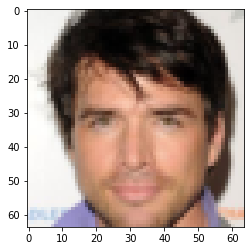

In [19]:
# preliminary testing
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np


train_file = Path("/content/gdrive/My Drive/CIS680_2019/HW4/train.npz")
train_data = np.load(train_file, allow_pickle=True)['arr_0'].astype(np.uint8)
print(train_data.shape)

test_file = Path("/content/gdrive/My Drive/CIS680_2019/HW4/test.npz")
test_data = np.load(test_file, allow_pickle=True)['arr_0'].astype(np.uint8)
print(test_data.shape)

plt.imshow(train_data[1])

In [0]:
# torch and torchvision imports
import torch
from torchvision import datasets, transforms
import numpy as np
from pathlib import Path
from torchvision.transforms.functional import to_pil_image


class HW4Dataset(torch.utils.data.Dataset):
  def __init__(self, path):
    self.path = path
    self.transform_toLowRes = transforms.Compose(
                              [transforms.ToPILImage(),
                               transforms.Resize((16,16)),
                               transforms.Resize((64,64)),
                               transforms.ToTensor()])
    
    self.transform_toTensor = transforms.Compose(
                            [transforms.ToTensor()])

    self.image_data = np.load(path, allow_pickle=True)['arr_0'].astype(np.uint8)
    
  def __getitem__(self, index):
    test_image = self.transform_toTensor(self.image_data[index])
    train_image = self.transform_toLowRes(self.image_data[index])
    return train_image, test_image
  
  def process_image(self,image):
    return 0

  def __len__(self):
    count = self.image_data.shape[0]
    return count # number of images


In [47]:
# Create test and train datasets
torch.manual_seed(0)

#!!!!!!!!!!change to wherever data is located

data_folder = Path("/content/gdrive/My Drive/CIS680_2019/HW4/")

train_file = Path("/content/gdrive/My Drive/CIS680_2019/HW4/train.npz")
test_file = Path("/content/gdrive/My Drive/CIS680_2019/HW4/test.npz")

trainset = HW4Dataset(train_file)
testset = HW4Dataset(test_file)

print(len(trainset),len(testset))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32)
sample_testloader = torch.utils.data.DataLoader(testset, batch_size=1)

print(len(trainloader),len(testloader))

20000 1000
625 32


# Test the Dataset

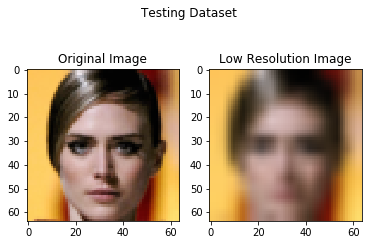

In [22]:
import matplotlib.pyplot as plt
import cv2
import random
from torchvision.transforms.functional import to_pil_image

index = random.randint(0,len(trainset))

image,label = trainset[index]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Testing Dataset')
ax1.set_title('Original Image')
ax2.set_title('Low Resolution Image')

ax1.imshow(to_pil_image(label))
ax2.imshow(to_pil_image(image))


# Model Definition

Define the four models (maybe a good idea to split these out into their own blocks?)

In [0]:
cd /content/gdrive/My\ Drive/CIS680_2019/HW4/PerceptualSimilarity

In [62]:
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision
from pathlib import Path
import cv2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    
    # Encoder
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride = 2, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride = 2, padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride = 2, padding=1)
    self.bn3 = nn.BatchNorm2d(128)
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride = 2, padding=1)
    self.bn4 = nn.BatchNorm2d(256)
    self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride = 2, padding=1)
    self.bn5 = nn.BatchNorm2d(512)

    # Decoder
    self.t_conv1 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride = 2, padding=1)
    self.t_bn1 = nn.BatchNorm2d(256)
    self.t_conv2 = nn.ConvTranspose2d(in_channels=256*2, out_channels=128, kernel_size=4, stride = 2, padding=1)
    self.t_bn2 = nn.BatchNorm2d(128)
    self.t_conv3 = nn.ConvTranspose2d(in_channels=128*2, out_channels=64, kernel_size=4, stride = 2, padding=1)
    self.t_bn3 = nn.BatchNorm2d(64)
    self.t_conv4 = nn.ConvTranspose2d(in_channels=64*2, out_channels=32, kernel_size=4, stride = 2, padding=1)
    self.t_bn4 = nn.BatchNorm2d(32)
    self.t_conv5 = nn.ConvTranspose2d(in_channels=32*2, out_channels=16, kernel_size=4, stride = 2, padding=1)
    self.t_bn5 = nn.BatchNorm2d(16)
    self.t_conv6 = nn.ConvTranspose2d(in_channels=19, out_channels=3, kernel_size=3, stride = 1, padding=1)
    # self.t_conv6_1 = nn.Conv2d(in_channels=19, out_channels=3, kernel_size=3, stride = 1, padding=1)

  def forward(self, X):
    
    enc1 = F.leaky_relu(self.bn1(self.conv1(X)))
    enc2 = F.leaky_relu(self.bn2(self.conv2(enc1)))
    enc3 = F.leaky_relu(self.bn3(self.conv3(enc2)))
    enc4 = F.leaky_relu(self.bn4(self.conv4(enc3)))
    enc5 = F.leaky_relu(self.bn5(self.conv5(enc4)))

    # decoder forward
    dec1 = F.leaky_relu(self.t_bn1(self.t_conv1(enc5)))
    dec1 = torch.cat((dec1,enc4), 1)   # skip connnections

    dec2 = F.leaky_relu(self.t_bn2(self.t_conv2(dec1)))
    dec2 = torch.cat((dec2,enc3), 1)
    
    dec3 = F.leaky_relu(self.t_bn3(self.t_conv3(dec2)))
    dec3 = torch.cat((dec3,enc2), 1)
    
    dec4 = F.leaky_relu(self.t_bn4(self.t_conv4(dec3)))
    dec4 = torch.cat((dec4,enc1), 1)

    dec5 = F.leaky_relu(self.t_bn5(self.t_conv5(dec4)))
    dec5 = torch.cat((dec5,X), 1)

    dec6 = torch.tanh(self.t_conv6(dec5))
    
    return dec6

class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride = 2, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride = 2, padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride = 2, padding=1)
    self.bn3 = nn.BatchNorm2d(128)
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride = 2, padding=1)
    self.bn4 = nn.BatchNorm2d(256)
    self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride = 2, padding=1)
    self.bn5 = nn.BatchNorm2d(512)
    self.conv6 = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=3, stride = 2, padding=1)

  def forward(self, X):
    X = F.leaky_relu(self.bn1(self.conv1(X)))
    X = F.leaky_relu(self.bn2(self.conv2(X)))
    X = F.leaky_relu(self.bn3(self.conv3(X)))
    X = F.leaky_relu(self.bn4(self.conv4(X)))
    X = F.leaky_relu(self.bn5(self.conv5(X)))
    X = torch.sigmoid(self.conv6(X))
    return X

import models
lpips_model = models.PerceptualLoss(model='net-lin', net='alex', use_gpu=True, spatial=False)

gen_model = Generator().to(device)
disc_model = Discriminator().to(device)
print(gen_model, disc_model)

gen_optimizer = optim.Adam(gen_model.parameters(), lr=1e-4)
disc_optimizer = optim.Adam(disc_model.parameters(), lr=1e-4)

reconstruction_loss = []  
gan_loss = []
validation_loss = []

def train():
  gen_model.train()
  disc_model.train()

  train_loss = 0

  for images, gt_highres_images in trainloader:
    images,gt_highres_images = images.to(device), gt_highres_images.to(device)
    
    # Update Discriminator
    disc_optimizer.zero_grad()

    gen_out = gen_model(images)

    disc_out_gen = disc_model(gen_out).squeeze()
    labels_gen = torch.zeros(disc_out_gen.shape,device=device)

    disc_out_gt = disc_model(gt_highres_images).squeeze()
    labels_gt = torch.ones(disc_out_gt.shape, device=device)

    pred_labels = torch.cat((disc_out_gen,disc_out_gt))
    gt_labels = torch.cat((labels_gen,labels_gt))
    
    gan_bce_loss =  F.binary_cross_entropy(pred_labels,gt_labels, reduction='mean')

    gan_bce_loss.backward()

    disc_optimizer.step()

    # Update Generator
    gen_optimizer.zero_grad()
    disc_optimizer.zero_grad()

    gen_out = gen_model(images)
    disc_out_gen = disc_model(gen_out).squeeze()
    labels_gen = torch.zeros(disc_out_gen.shape,device=device)

    gan_bce_loss =  F.binary_cross_entropy(disc_out_gen,labels_gen, reduction='mean')
    pixel_mse_loss = F.mse_loss(gen_out,gt_highres_images, reduction='mean')
    
    loss = pixel_mse_loss + gan_bce_loss

    loss.backward()

    gen_optimizer.step()

    train_loss += loss.item()
        
    reconstruction_loss.append(pixel_mse_loss)
    gan_loss.append(gan_bce_loss)

  return train_loss/len(trainloader)

def plot_test_image(label,image,generated):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
  fig.suptitle('Intermediate Test Image')
  ax1.set_title('Original')
  ax2.set_title('Low-Res Input')
  ax3.set_title('Super-Resolution Image')
  ax1.imshow(to_pil_image(label))
  ax2.imshow(to_pil_image(image))
  ax3.imshow(to_pil_image(generated))
  # plt.show()

def test():
  
  gen_model.eval()
  disc_model.eval()
  test_loss = 0  
  lpips_score = 0

  with torch.no_grad():
    for i,test_data in enumerate(testloader):
      images,gt_highres_images = test_data[0].to(device), test_data[1].to(device)
      gen_out = gen_model(images)
      disc_out_gen = disc_model(gen_out).squeeze()
      labels_gen = torch.zeros(disc_out_gen.shape,device=device)

      gan_bce_loss =  F.binary_cross_entropy(disc_out_gen,labels_gen, reduction='mean')
      pixel_mse_loss = F.mse_loss(gen_out,gt_highres_images, reduction='mean')
    
      loss = pixel_mse_loss + gan_bce_loss

      test_loss += loss.item()

      lpips_score += torch.mean(lpips_model.forward(gen_out,gt_highres_images).squeeze())

      if i == 0:
        fixed_low = images[0].detach().cpu()
        fixed_high = gt_highres_images[0].detach().cpu()
        fixed_super = gen_out[0].detach().cpu()
        # print(gan_bce_loss.item(),pixel_mse_loss.item())
        plot_test_image(fixed_high,fixed_low,fixed_super)

  return test_loss/len(testloader), lpips_score/len(testloader)


Setting up Perceptual loss...
Loading model from: /content/gdrive/My Drive/CIS680_2019/HW4/PerceptualSimilarity/models/weights/v0.1/alex.pth
...[net-lin [alex]] initialized
...Done
Generator(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=Tru

In [0]:
# sanity check for the model and the losses

with torch.no_grad():
  for images, gt_highres_images in testloader:
    images,gt_highres_images = images.to(device), gt_highres_images.to(device)
    print(images.shape , gt_highres_images.shape)
    gen_out = gen_model(images)
    print(gen_out.shape)

    disc_out_gen = disc_model(gen_out).squeeze()
    print(disc_out_gen.shape)
    labels_gen = torch.zeros(disc_out_gen.shape,device=device)

    disc_out_gt = disc_model(gt_highres_images).squeeze()
    print(disc_out_gt.shape)
    labels_gt = torch.ones(disc_out_gt.shape, device=device)

    pred_labels = torch.cat((disc_out_gen,disc_out_gt))
    gt_labels = torch.cat((labels_gen,labels_gt))

    print(pred_labels.shape,gt_labels.shape)

    gan_bce_loss =  F.binary_cross_entropy(pred_labels,gt_labels, reduction='mean')
    print(gan_bce_loss)

    pixel_mse_loss = F.mse_loss(gen_out,gt_highres_images, reduction='mean')
    print(pixel_mse_loss)

    break


torch.Size([32, 3, 64, 64]) torch.Size([32, 3, 64, 64])
torch.Size([32, 3, 64, 64])
torch.Size([32])
torch.Size([32])
torch.Size([64]) torch.Size([64])
tensor(0.7191, device='cuda:0')
tensor(1.2851, device='cuda:0')


# Train your networks

It might be good to save checkpoints and reload from the most recent. This is due to time constraints inside of colab. (Probably a good idea to train each part in separate blocks?)

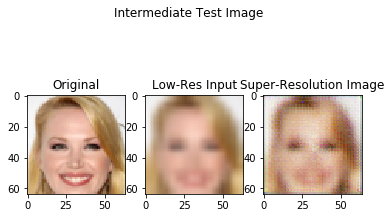

Epoch 0, Train Loss: 0.0887189, Test Loss: 0.0110445, LPIPS Score: 0.2835457
Epoch 1, Train Loss: 0.0088298, Test Loss: 0.0067858, LPIPS Score: 0.2440747
Epoch 2, Train Loss: 0.0065385, Test Loss: 0.0056530, LPIPS Score: 0.2108377


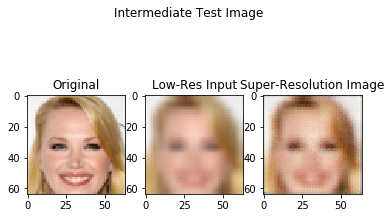

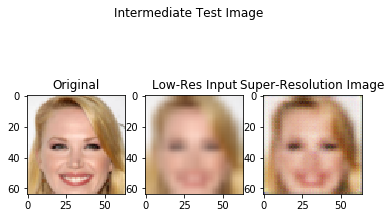

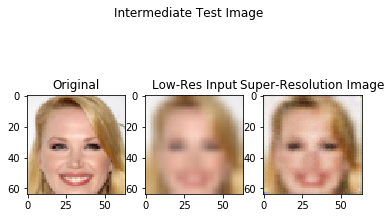

Epoch 3, Train Loss: 0.0056255, Test Loss: 0.0049891, LPIPS Score: 0.1942551
Epoch 4, Train Loss: 0.0085057, Test Loss: 0.0087887, LPIPS Score: 0.2316804
Epoch 5, Train Loss: 0.0065735, Test Loss: 0.0057107, LPIPS Score: 0.2021693


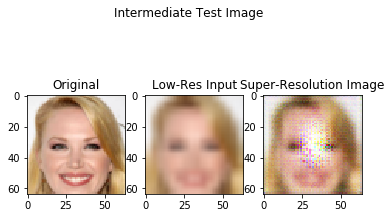

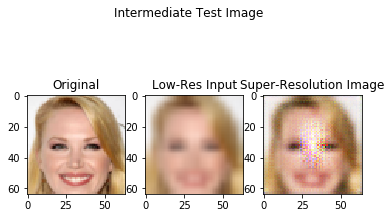

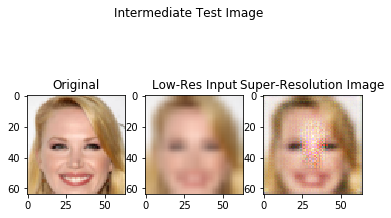

Epoch 6, Train Loss: 0.0054952, Test Loss: 0.0050799, LPIPS Score: 0.1935863
Epoch 7, Train Loss: 0.0050067, Test Loss: 0.0048160, LPIPS Score: 0.1909812
Epoch 8, Train Loss: 0.0047146, Test Loss: 0.0046094, LPIPS Score: 0.1830622


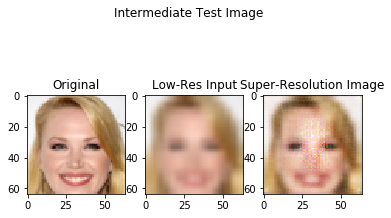

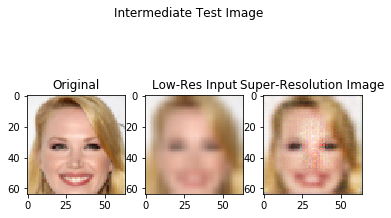

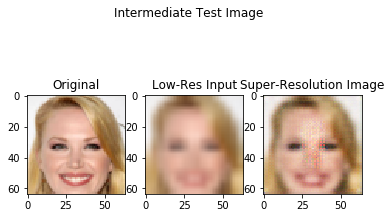

Epoch 9, Train Loss: 0.0044928, Test Loss: 0.0042917, LPIPS Score: 0.1820644
Epoch 10, Train Loss: 0.0043419, Test Loss: 0.0041388, LPIPS Score: 0.1779470
Epoch 11, Train Loss: 0.0041780, Test Loss: 0.0043276, LPIPS Score: 0.1801696


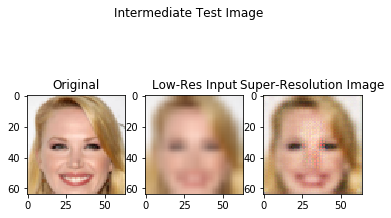

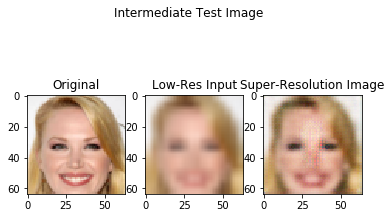

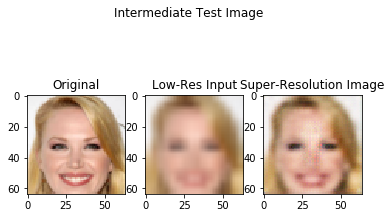

Epoch 12, Train Loss: 0.0041048, Test Loss: 0.0038372, LPIPS Score: 0.1718980
Epoch 13, Train Loss: 0.0038996, Test Loss: 0.0037552, LPIPS Score: 0.1700771
Epoch 14, Train Loss: 0.0037560, Test Loss: 0.0036557, LPIPS Score: 0.1600126


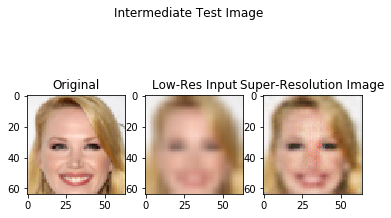

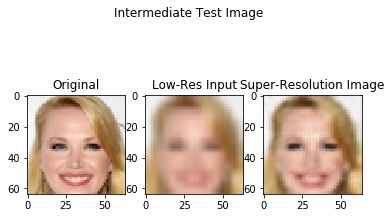

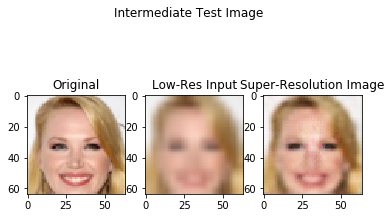

Epoch 15, Train Loss: 0.0036158, Test Loss: 0.0034246, LPIPS Score: 0.1519241
Epoch 16, Train Loss: 0.0034652, Test Loss: 0.0032877, LPIPS Score: 0.1469907
Epoch 17, Train Loss: 0.0033310, Test Loss: 0.0031446, LPIPS Score: 0.1381402


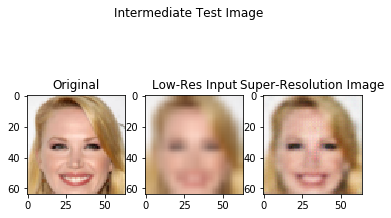

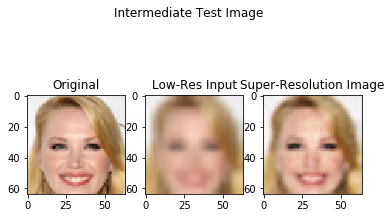

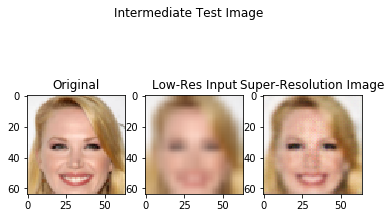

Epoch 18, Train Loss: 0.0032243, Test Loss: 0.0030702, LPIPS Score: 0.1330222
Epoch 19, Train Loss: 0.0030989, Test Loss: 0.0030886, LPIPS Score: 0.1249984
Epoch 20, Train Loss: 0.0033967, Test Loss: 0.0086936, LPIPS Score: 0.1284749


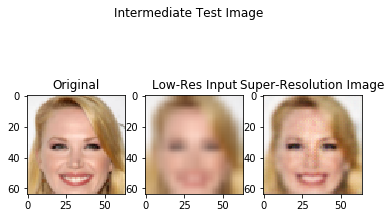

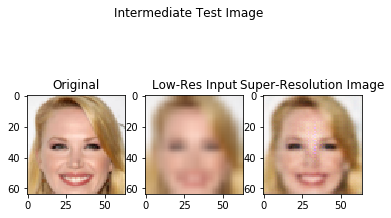

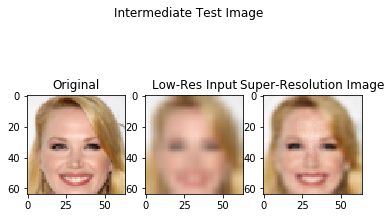

Epoch 21, Train Loss: 0.0030368, Test Loss: 0.0746782, LPIPS Score: 0.1234871
Epoch 22, Train Loss: 0.0029308, Test Loss: 0.0028243, LPIPS Score: 0.1171703
Epoch 23, Train Loss: 0.0028454, Test Loss: 0.0065690, LPIPS Score: 0.1142501


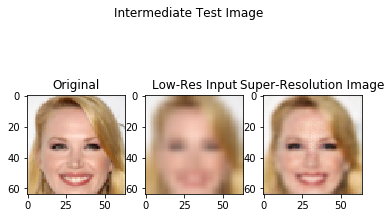

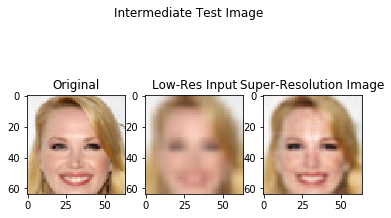

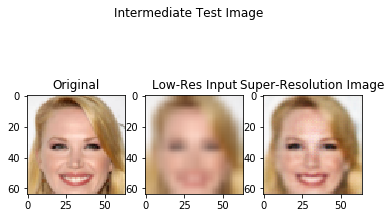

Epoch 24, Train Loss: 0.0027761, Test Loss: 0.0610375, LPIPS Score: 0.1110905
Epoch 25, Train Loss: 0.0026978, Test Loss: 0.0222541, LPIPS Score: 0.1091217


KeyboardInterrupt: ignored

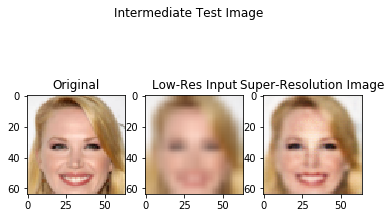

In [63]:
epochs = 30
training_loss = []
validation_loss = []
val_lpips_score = []

for e in range(epochs):

    train_loss = train()
    test_loss,lpips_score = test()

    training_loss.append(train_loss)
    validation_loss.append(test_loss)
    val_lpips_score.append(lpips_score)

    if e%3 == 0:
      plt.show() 

    print(f'Epoch {e}, Train Loss: {train_loss:.7f}, Test Loss: {test_loss:.7f}, LPIPS Score: {lpips_score:.7f}' )


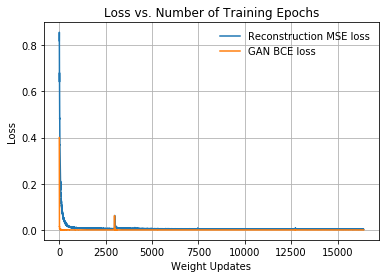

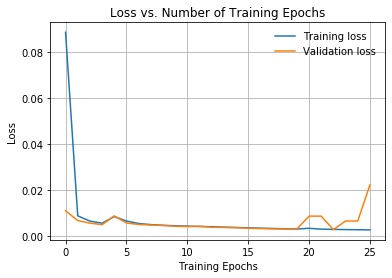

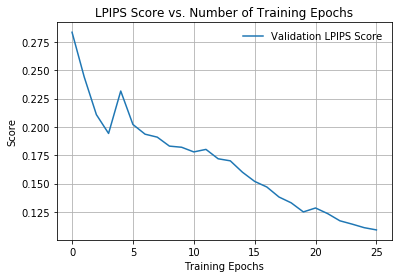

In [70]:
# Plots

torch.save({'gen_model_state_dict': gen_model.state_dict(),'disc_model_state_dict': disc_model.state_dict()}, data_folder / 'srgan_3.pt')

plt.figure()
plt.title("Loss vs. Number of Training Epochs")
plt.xlabel("Weight Updates")
plt.ylabel("Loss")
plt.plot(reconstruction_loss, label='Reconstruction MSE loss')
plt.plot(gan_loss, label='GAN BCE loss')
plt.legend(frameon=False)
plt.grid()
plt.show()

plt.figure()
plt.title("Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(training_loss, label='Training loss')
plt.plot(validation_loss, label='Validation loss')
plt.legend(frameon=False)
plt.grid()
plt.show()

plt.figure()
plt.title("LPIPS Score vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Score")
plt.plot(val_lpips_score, label='Validation LPIPS Score')
plt.legend(frameon=False)
plt.grid()
plt.show()

# Test your networks

Did you remember to cut out a test set? If not you really should, test on images your network has never seen.

In [40]:
cd /content/gdrive/My\ Drive/CIS680_2019/HW4/PerceptualSimilarity

/content/gdrive/My Drive/CIS680_2019/HW4/PerceptualSimilarity


In [0]:
import models
lpips_model = models.PerceptualLoss(model='net-lin', net='alex', use_gpu=True, spatial=False)

gen_model.load_state_dict(torch.load(data_folder / 'srgan_1.pt')['gen_model_state_dict'])
disc_model.load_state_dict(torch.load(data_folder / 'srgan_1.pt')['disc_model_state_dict'])

gen_model.eval()
disc_model.eval()
test_loss = 0  

with torch.no_grad():
  pixel_mse_loss = 0
  lpips_score = 0
  for i,test_data in enumerate(testloader):
    images,gt_highres_images = test_data[0].to(device), test_data[1].to(device)
    gen_out = gen_model(images)
    disc_out_gen = disc_model(gen_out).squeeze()
    labels_gen = torch.zeros(disc_out_gen.shape,device=device)
    
    # gan_bce_loss =  F.binary_cross_entropy(disc_out_gen,labels_gen, reduction='mean')
    pixel_mse_loss += F.mse_loss(gen_out,gt_highres_images, reduction='mean')
    lpips_score = torch.mean(lpips_model.forward(gen_out,gt_highres_images).squeeze())
    print(lpips_score)
    # loss = pixel_mse_loss + gan_bce_loss

print(pixel_mse_loss/len(testloader))

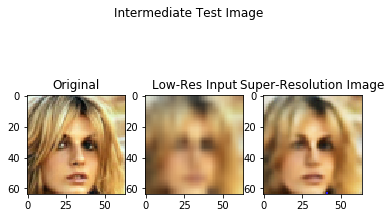

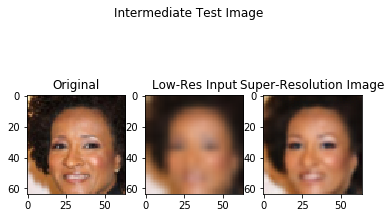

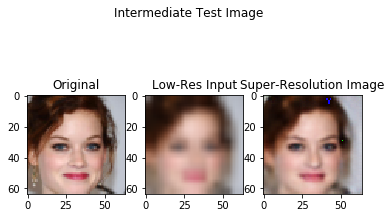

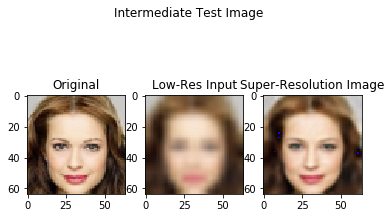

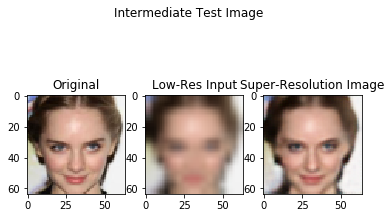

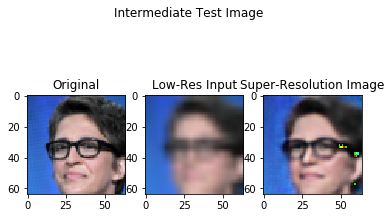

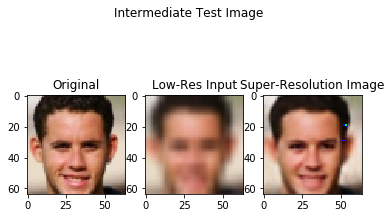

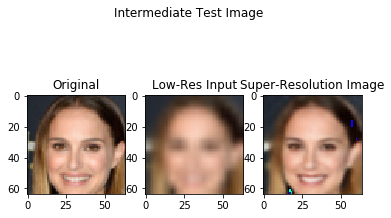

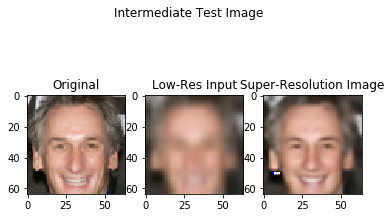

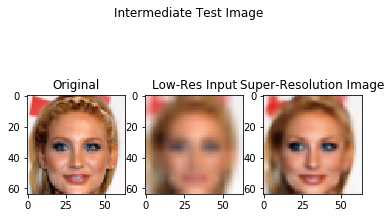

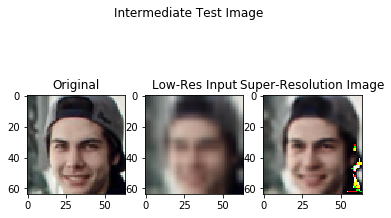

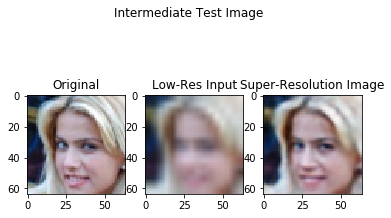

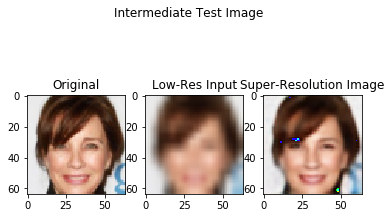

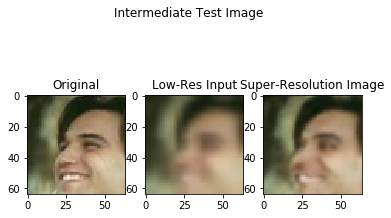

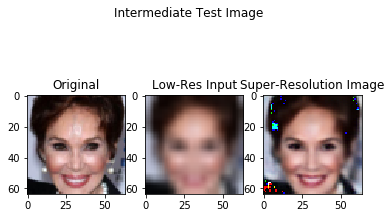

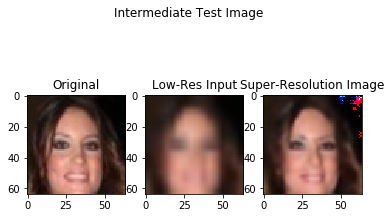

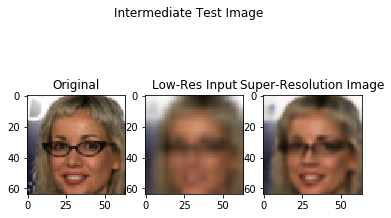

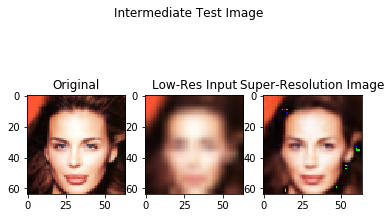

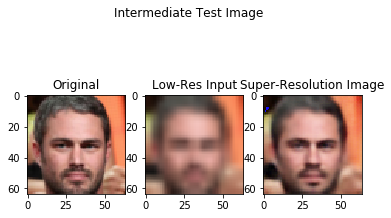

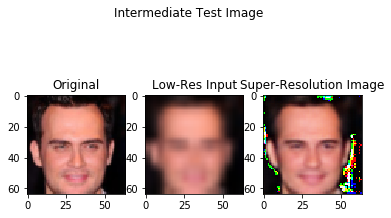

In [58]:
import random

#load saved model
gen_model.load_state_dict(torch.load(data_folder / 'srgan_1.pt')['gen_model_state_dict'])
disc_model.load_state_dict(torch.load(data_folder / 'srgan_1.pt')['disc_model_state_dict'])

gen_model.eval()
disc_model.eval()
test_loss = 0  

for i in range (0,20):
  idx = random.randint(0,len(testset)-1)
  images,gt_highres_images = testset[idx]

  images,gt_highres_images = images.to(device).unsqueeze(0), gt_highres_images.to(device).unsqueeze(0)
  gen_out = gen_model(images)
  disc_out_gen = disc_model(gen_out).squeeze()

  fixed_low = images[0].detach().cpu()
  fixed_high = gt_highres_images[0].detach().cpu()
  fixed_super = gen_out[0].detach().cpu()
  plot_test_image(fixed_high,fixed_low,fixed_super)
  plt.show()